In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, f1_score
from arff2pandas import a2p


%matplotlib inline

In [2]:
with open('OffComBR2.arff') as f, open('OffComBR3.arff') as g:
    data1 = a2p.load(f)
    data2 = a2p.load(f)
    data = data1.append(data2, ignore_index=True)

In [3]:
data = data.rename(columns = {'@@class@{no,yes}':'target','document@STRING':'text'})

In [4]:
data.head()

,target,text
0,yes,Votaram no PEZAO Agora tomem no CZAO
1,no,cuidado com a poupanca pessoal Lembram o que a...
2,no,Sabe o que eu acho engracado os nossos governa...
3,yes,os cariocas tem o que merecem um pessoal que s...
4,no,Podiam retirar dos lucros dos bancos


### Data Analysis

* Quantos dados de cada tipo temos?

In [5]:
feature_data = data['target'].value_counts()

In [6]:
feature_data

no     831
yes    419
Name: target, dtype: int64

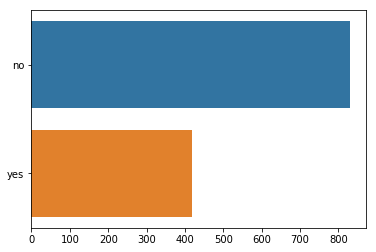

In [7]:
sns.barplot(x=feature_data.values, y=feature_data.index)

* Quão longo são os textos? do tipo ofensivo e não ofensivo

In [8]:
s1 = data[data['target'] == 'yes']['text'].str.len()
s2 = data[data['target'] == 'no']['text'].str.len()

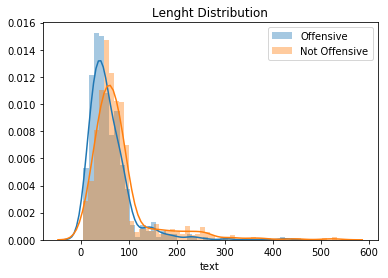

In [9]:
sns.distplot(s1, label='Offensive')
sns.distplot(s2, label='Not Offensive')
plt.title('Lenght Distribution')
plt.legend()

In [10]:
print(s1.mean(), s2.mean())

57.517899761336515 80.14320096269554


**Conclusion:** Textos não ofensivos são geralmente mais longos

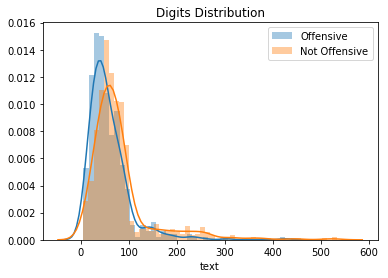

In [11]:
d1 = data[data['target'] == 'yes']['text'].str.replace(r'\d+', '').str.len()
sns.distplot(d1, label='Offensive')
d2 = data[data['target'] == 'no']['text'].str.replace(r'\d+', '').str.len()
sns.distplot(d2, label='Not Offensive')
plt.title('Digits Distribution')
plt.legend()

In [12]:
print('Offensive texts: {n1}\nNot Offensive texts: {n2}'.format(n1=d1.mean(), n2=d2.mean()))

Offensive texts: 57.517899761336515
Not Offensive texts: 80.14320096269554


**Obs:** Textos não ofensivos tem uma quantidade maior de digitos

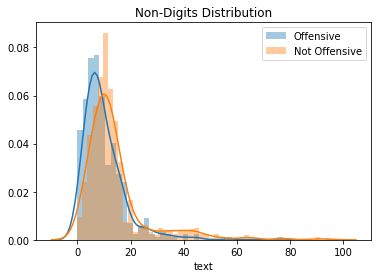

In [13]:
nd1 = data[data['target'] == 'yes']['text'].str.replace(r'\w+', '').str.len()
sns.distplot(nd1, label='Offensive')
nd2 = data[data['target'] == 'no']['text'].str.replace(r'\w+', '').str.len()
sns.distplot(nd2, label='Not Offensive')
plt.title('Non-Digits Distribution')
plt.legend()

In [14]:
print('Offensive texts: {n1}\nNot Offensive texts: {n2}'.format(n1=nd1.mean(), n2=nd2.mean()))

Offensive texts: 9.976133651551313
Not Offensive texts: 14.110709987966306


**Obs:** Textos não ofensivos tem uma presença maior de não digitos.

* Detalhes sobre a coluna target

In [15]:
data.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
no       831    828        PESQUISE E PARTICIPE Consulta Publica  PEC     2
yes      419    416  Pq o Morosita recebe ordens externas A ordem n...    2

### Training

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state=0)

* **CountVectorizer**

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

Vocabulary len: 3431
Longest word: kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk


In [18]:
x_train_vectorized = vect.transform(X_train)

In [19]:
x_train_vectorized.data

array([1, 1, 1, ..., 3, 1, 1])

In [20]:
values = x_train_vectorized.data
df = pd.DataFrame(data=values).T

In [21]:
df

,0,1,2,3,4,5,6,7,8,9,...,10441,10442,10443,10444,10445,10446,10447,10448,10449,10450
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,3,1,1


In [22]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=0.1)
model.fit(x_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [23]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

print(feature_names)
print(sorted_coef_index)


['abaixo' 'abarrotadas' 'abc' ... 'zozoi' 'zuados' 'zuar']
[   0 2000 2001 ... 2139 2679  856]


In [24]:
# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['abaixo' 'men' 'mendigos' 'menguinho' 'meninos' 'mensagens' 'mente'
 'mentir' 'melhores' 'mentira']

Largest Coefs: 
['de' 'que' 'nao' 'um' 'do' 'vai' 'da' 'com' 'no' 'mais']


In [25]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(vect.transform(X_test))
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 74.12%


* **Tfidf**

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=3).fit(X_train)

In [27]:
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

Vocabulary len: 675
Longest word: aposentadoria


In [28]:
X_train_vectorized = vect.transform(X_train)

In [29]:
X_train_vectorized.data

array([0.3137048 , 0.35805486, 0.39266908, ..., 0.2710915 , 0.13512801,
       0.25406961])

In [30]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [31]:
feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['ministra' 'dizer' 'real' 'paga' 'reais' 'paises' 'duras' 'parabens'
 'educacao' 'rajkazblanks']

Largest Coefs: 
['de' 'que' 'vai' 'um' 'nao' 'do' 'idiota' 'da' 'seu' 'sua']


In [32]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(vect.transform(X_test))
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 70.29%


**Feature Engineering**

In [33]:
def add_feature(X, feature_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_add).T], 'csr')

**First Model with**

First, let's ignore terms that have a document frequency strictly lower than 3. Using this document-term matrix and an additional feature, the length of document (number of characters), we will test how our Tfidf performs.

In [34]:
vect = TfidfVectorizer(min_df=3).fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())

Vocabulary len: 675
Longest word: aposentadoria


In [35]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [36]:
index = np.array(vect.get_feature_names() + ['length_of_doc'])
values  = model.coef_[0]
features_series = pd.Series(data=values,index=index)

print('Smallest Coefs:\n{}\n'.format(features_series.nsmallest(10).index.values.tolist()))
print('Largest Coefs: \n{}'.format(features_series.nlargest(10).index.values.tolist()))

Smallest Coefs:
['acabar', 'acaso', 'acham', 'acreditar', 'alcance', 'alguem', 'algum', 'alguma', 'alguns', 'am']

Largest Coefs: 
['length_of_doc', 'de', 'que', 'vai', 'um', 'nao', 'do', 'idiota', 'da', 'seu']


In [37]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
    
y_pred = model.predict(X_test_vectorized)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 70.29%


#### Second model

Tf-idf: 
* Ignorar termos com frequencia abaixo de 5
* word n-grams n=1 to n=3 (unigrams, bigrams and trigrams)

Features adicionais: 

* Tamanho do documento (quantidade de caracteres)
* Número de digitos por documento

In [65]:
vect = TfidfVectorizer(min_df=5, ngram_range=(1, 3)).fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\D+', '').str.len())

Vocabulary len: 413
Longest word: em pontos corridos


In [66]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [67]:
index = np.array(vect.get_feature_names() + ['length_of_doc', 'digit_count'])
values  = model.coef_[0]
features_series = pd.Series(data=values,index=index)

print('Smallest Coefs:\n{}\n'.format(features_series.nsmallest(10).index.values.tolist()))
print('Largest Coefs: \n{}'.format(features_series.nlargest(10).index.values.tolist()))

Smallest Coefs:
['acabar', 'acabar com', 'alguem', 'alguma', 'alguns', 'anos de', 'aos', 'aumento', 'colocar', 'com os']

Largest Coefs: 
['length_of_doc', 'de', 'que', 'vai', 'um', 'do', 'nao', 'idiota', 'da', 'seu']


In [68]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\D+', '').str.len())
    
y_pred = model.predict(X_test_vectorized)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 69.33%


#### Third model

Count Vectorizer  
* Termos com frequência abaixo de 5  
* N-grams de n=2 a n=5  

To tell Count Vectorizer to use character n-grams we pass in analyzer='char_wb' which creates character n-grams only from text inside word boundaries. This should make the model more robust to spelling mistakes.




Features Adicionais:

* Tamanho do documento (número de caracteres)  
* Número de digítos por caracter
* Número de digitos que não sejam palavras (Letras, digitos ou underscore.)

In [57]:
vect = CountVectorizer(min_df=1, ngram_range=(2, 5), analyzer='char_wb').fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\D+', '').str.len())
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\w+', '').str.len())

Vocabulary len: 20574
Longest word:  esse


In [58]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [59]:
index = np.array(vect.get_feature_names() + ['length_of_doc', 'digit_count', 'non_word_char_count'])
values = model.coef_[0]
features_series = pd.Series(data=values,index=index)

print('Smallest Coefs:\n{}\n'.format(features_series.nsmallest(10).index.values.tolist()))
print('Largest Coefs: \n{}'.format(features_series.nlargest(10).index.values.tolist()))

Smallest Coefs:
[' aba', ' abai', ' abar', ' abc', ' abc ', ' abs', ' absu', ' acao', ' acas', ' acel']

Largest Coefs: 
['length_of_doc', 'non_word_char_count', 'a ', 'o ', 'e ', 'kk', 'kkk', 'kkkk', ' e', ' d']


In [60]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\D+', '').str.len())
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\w+', '').str.len())
    
y_pred = model.predict(X_test_vectorized)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 75.40%
